# Olivetti Faces Generation

Using the olivetti faces dataset, generate faces with CVAE.

The olivetti faces can be loaded from scikit-learn with the following:
```python
from sklearn.datasets import fetch_olivetti_faces
```

Then using a CVAE, that you will train on the dataset, try to generate new images of some persons of the dataset.

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

X, y = fetch_olivetti_faces().images, fetch_olivetti_faces().target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data
n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

In [2]:
import tensorflow as tf

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5*z_log_var) * epsilon

In [3]:
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy

def vae_loss(x, x_decoded_mean):
    classic_loss = mean_squared_error(x, x_decoded_mean)*n_pixels
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = -0.5*tf.reduce_sum(kl_loss, axis=-1)
    vae_loss = tf.reduce_mean(classic_loss + kl_loss)    
    return vae_loss

In [4]:
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate
from tensorflow.keras.models import Model

# Define the number of classes: here 10 for 40 faces
n_classes = 40

intermediate_dim = 512
latent_dim = 2
n_pixels = 4096
batch_size = 128

# Define the encoder part
x = Input(shape=(n_pixels,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Define z
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Here is the only difference: merge latent space with labels
label = Input(shape=(n_classes,))
zc = Concatenate(axis=1)([z, label])

# Define the decoder part
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(n_pixels, activation='sigmoid')
h_decoded = decoder_h(zc)
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
cvae = Model([x, label], x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model([x, label], z_mean)

In [5]:
# Put labels to one hot vectors
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

cvae.compile(optimizer='adam', loss=vae_loss, experimental_run_tf_function=False)

cvae.fit([X_train, y_train_cat], X_train, epochs=100,
        batch_size=batch_size, validation_data=([X_test, y_test_cat], X_test))

Train on 320 samples, validate on 80 samples
Epoch 1/100
320/320 [==============================] - 0s 920us/sample - loss: 7035.9159 - val_loss: 331.1130
Epoch 2/100
320/320 [==============================] - 0s 415us/sample - loss: 348.3228 - val_loss: 417.6637
Epoch 3/100
320/320 [==============================] - 0s 426us/sample - loss: 416.9969 - val_loss: 417.8188
Epoch 4/100
320/320 [==============================] - 0s 535us/sample - loss: 395.9144 - val_loss: 344.3052
Epoch 5/100
320/320 [==============================] - 0s 531us/sample - loss: 312.9917 - val_loss: 249.5120
Epoch 6/100
320/320 [==============================] - 0s 463us/sample - loss: 220.2206 - val_loss: 175.2986
Epoch 7/100
320/320 [==============================] - 0s 432us/sample - loss: 155.5305 - val_loss: 140.6803
Epoch 8/100
320/320 [==============================] - 0s 525us/sample - loss: 130.0381 - val_loss: 138.0369
Epoch 9/100
320/320 [==============================] - 0s 467us/sample - loss: 128

320/320 [==============================] - 0s 407us/sample - loss: 43.7846 - val_loss: 50.0580
Epoch 77/100
320/320 [==============================] - 0s 421us/sample - loss: 43.5017 - val_loss: 49.6475
Epoch 78/100
320/320 [==============================] - 0s 400us/sample - loss: 42.9859 - val_loss: 49.6651
Epoch 79/100
320/320 [==============================] - 0s 398us/sample - loss: 42.3521 - val_loss: 49.1211
Epoch 80/100
320/320 [==============================] - 0s 395us/sample - loss: 42.2949 - val_loss: 49.3309
Epoch 81/100
320/320 [==============================] - 0s 385us/sample - loss: 41.8022 - val_loss: 48.7656
Epoch 82/100
320/320 [==============================] - 0s 389us/sample - loss: 41.6538 - val_loss: 48.8492
Epoch 83/100
320/320 [==============================] - 0s 385us/sample - loss: 41.2709 - val_loss: 47.8921
Epoch 84/100
320/320 [==============================] - 0s 398us/sample - loss: 40.7968 - val_loss: 47.9874
Epoch 85/100
320/320 [===================

In [6]:
# generator, from latent space and labels to reconstructed inputs
decoder_input = Input(shape=(latent_dim+n_classes,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

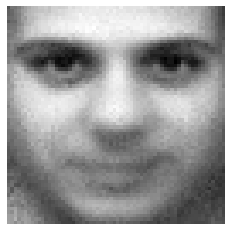

In [7]:
import matplotlib.pyplot as plt

# Choose the face to generate
face_to_generate = 8

# Convert it to categorical
val = to_categorical(face_to_generate, num_classes=n_classes)

# Create the input vector (latent value and digit class)
input_vector = np.zeros((1, latent_dim + n_classes))
input_vector[0,latent_dim:] = val

# Generate the output
generated_x = generator.predict(input_vector)

# Display the output
plt.imshow(generated_x.reshape(64, 64), cmap = plt.cm.gray)
plt.axis('off')
plt.show()

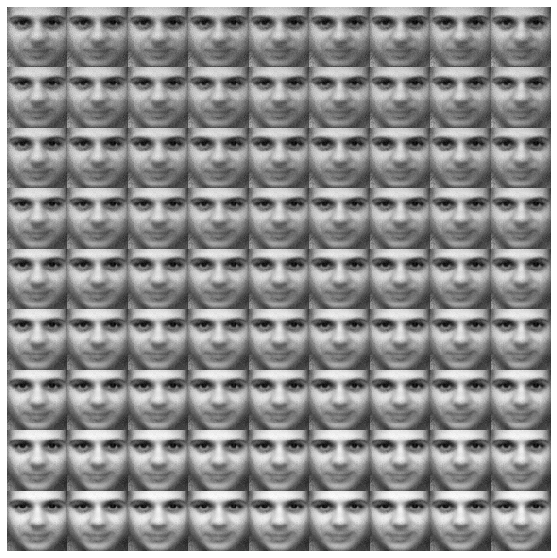

In [8]:
# display a 2D manifold of the face
n = 9  # figure with 9x9 faces
face_size = 64

figure = np.zeros((face_size * n, face_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-0.8, 0.8, n)
grid_y = np.linspace(-0.8, 0.8, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Create the input vector (latent value and digit class)
        input_vector = np.zeros((1, latent_dim + n_classes))
        input_vector[0,latent_dim:] = val
        input_vector[0, 0]=xi
        input_vector[0, 1]=yi
        
        generated_x = generator.predict(input_vector)
        digit = generated_x[0].reshape(face_size, face_size)
        figure[i * face_size: (i + 1) * face_size,
               j * face_size: (j + 1) * face_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap = plt.cm.gray)
plt.axis('off')
plt.show()